<a href="https://colab.research.google.com/github/k-ferry/cs676-fall-2025/blob/main/project-1/deliverable2/deliverable1v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credibility Scoring for eBay Soccer Card Listings in a RAG Chatbot

# Abstract
We propose and evaluate a credibility scoring component for a Retrieval-Augmented Generation (RAG) chatbot that surfaces soccer card listings from eBay. The system assigns a per-URL credibility score to help users judge the reliability of cited sources and prioritize higher-quality listings. Our approach is hybrid: a transparent rule-based layer (domain/transport, content heuristics, and eBay-specific seller/listing signals) plus a lightweight ML calibration (logistic regression) that learns to re-weight signals from labeled data. We present the prototype algorithm, a stable JSON API, initial experiments, and a roadmap to production.

# Introduction & Scope
Large language models augemented with retrieval (RAG) can cite live source for pricing, comps, and context.  However, cited sources vary in reliability.  For sports cards on marketplaces like eBay, credibility as the likelihood that a listing accurately respresents what it claims (authenticity, condition clarity, seller reliability, sufficient evidence) and that it's a solid source to support chatbot responses.

The report describes the design and evaluation of a credibility scorer that:


*   Takes a URL as input
*   Computes interpretable signals (domain prior seller feedback %, returns policy, specific/keywords, etc)
*   Aggregates them into a 0-100 score, optionally calibrated via a small supervised model
*   Returns a stable JSON the chatbot can display alongside citations.

In [1]:
# Imports & Config

# Purpose of this cell:
# - Import only what we need for the core prototype to keep fast and stable
# - Set conservaitve network defaults (timeouts/headers) so production integration goes smoother.
# - Pre-compile a domain regex for eBay to enable platform-specific signals later.

from __future__ import annotations
# ^ Enables "forward references" for type hints (e.g., using a class/type name before it's defined)
# Helps keep the file order flexible

import dataclasses
import json
import math
import re
import time
import typing as t
from dataclasses import dataclass
from datetime import datetime, timezone
from urllib.parse import urlparse
# ^ Standard-library imports only so far:
# - dataclasses/dataclass: simple typed containers for signals and score results
# - json: for serializing output/dicts
# - math: numeric helpers (Log10, exp for squashing function)
# - re: regular expressions for parsing text/html heuristics
# - time: peformance timing (ms) for basic benchmarking/metadata
# - typing: type hints, e.g., t.Sequence[float]
# - datetime/timezone: timestamps in UTC (stable logging and reproducability)
# - urllib.parse.urlparse: strict URL validation and parsing

# Optional imports guarded at runtime; keep import-time light and notebook robust.
# Optional HTML parser (robust text & tag handling)
try:
    from bs4 import BeautifulSoup  # type: ignore
except Exception:
    BeautifulSoup = None  # graceful fallback to regex path

try:
    import requests  # HTTP client used only when dry_run=False
except Exception:
    requests = None  # # If requests isn't available (or blocked), we degrade gracefully.
# ^ Rationale: Deliverable 1 must run even without network access (e.g., in Colab or CI).
#   The code uses a "dry_run" mode that synthesizes HTML; this keeps tests deterministic.

# Optional libs used later (pandas for tables; sklearn for D2 calibration)
try:
    import pandas as pd  # tabular display and simple data wrangling for ranked outputs
except Exception:
    pd = None # Allow notebook to run even if pandas isn't installed.

try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    import numpy as np
except Exception:
    LogisticRegression = None
    Pipeline = None
    StandardScaler = None
    train_test_split = None
    np = None

# --- Network defaults (used only if dry_run=False) ---
DEFAULT_TIMEOUT_S = 6.0
# ^ Per-request timeout (seconds).  Conservative to avoid hanging UI calls.

DEFAULT_HEADERS = {
    # Custom UA string: polite + traceable in server logs; helps avoid some bot blocks.
    "User-Agent": "CredScorer/0.1 (+https://example.edu/project)",
    # Accept header: prefer HTML/XML; still accept anything to be resilient.
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
}

# --- Platform detector (precompiled regex) ---
# Matches eBay primary domain and common regional TLDs (ebay.com, ebay.co.uk, ebay.de, etc.).
EbayLike = re.compile(r"(^|\.)ebay\.(com|co\.[a-z]{2}|[a-z]{2})$", re.I)


# 2. Problem Framing
Goal: Assign each listing a credibility score useful for ranking and for user-facing explanation.

Assumption:


*   Seller reputation (feedback %, count, Top Rated) correlates with trust.
*   Listings with clear photos, specific card attributes (grade, serial, set), and return policies are more reliable
*   Very short or ambiguous descriptions reduce credibility
*   Sentiment terms can be a weak prior (e.g. "creased", "OC", "gem", "clean")

Next-steps:  We do not yet authenticate PSA certs, verify images, or compute fair market value.  These are roadmap items.

In [2]:
# Cell 2 — Data Structures & Stable Response Schema
# -------------------------------------------------
# Purpose:
# 1) Define small, typed containers for signals and results (using dataclasses).
# 2) Provide a *single stable* JSON contract via `response_json(...)` that every caller can rely on.
#    This avoids brittle “if error, shape is different” problems when we integrate (Deliverable 3).

@dataclass
class Signal:
    """
    An interpretable scoring *component* (feature) contributing to credibility.

    Fields
    ------
    name : str
        Short identifier (e.g., "domain_prior", "seller_feedback_pct").
    value : float
        Normalized feature value in [0, 1]. Higher is better (more credible/desirable).
    weight : float
        Weight in [0, 1] reflecting this signal's *influence* in the current heuristic model.
        (In Deliverable 2, a learned model can reweight via calibration.)
    rationale : str
        Human-readable explanation so the UI/report can show *why* a score moved.
    """
    name: str
    value: float
    weight: float
    rationale: str

    def contribution(self) -> float:
        """
        Weighted contribution for this signal.
        We keep the math simple and transparent: contribution = value * weight.

        Returns
        -------
        float
            Contribution in [0, 1] (typically small), later aggregated and squashed to [0, 100].
        """
        return self.value * self.weight


@dataclass
class ScoreResult:
    """
    Internal container for an entire scoring run on a single URL.
    We keep this separate from the external JSON payload so we can evolve internals
    without breaking the API contract.

    Fields
    ------
    url : str
        The URL that was evaluated.
    status : str
        "ok" for success; or "invalid_url", "fetch_error", etc. for graceful failure modes.
    score_abs : float
        Absolute score after aggregation and squashing to [0, 100].
    score_pct : float | None
        Optional percentile vs a cohort (if provided by batch ranking).
    signals : list[Signal]
        All computed signals with values/weights and rationales.
    errors : list[str]
        Non-fatal errors/warnings encountered (e.g., network timeouts).
    meta : dict[str, t.Any]
        Extra metadata (host, is_ebay flag, timestamps, timings, version tag).
    """
    url: str
    status: str
    score_abs: float
    score_pct: float | None
    signals: list[Signal]
    errors: list[str]
    meta: dict[str, t.Any]


def response_json(result: ScoreResult) -> dict:
    """
    Convert internal ScoreResult into a *stable* JSON/dict that clients can consume.
    This is the public contract for Deliverable 1/2/3. Keep this structure stable.

    Returns
    -------
    dict
        {
          "url": <str>,
          "status": <"ok" | "invalid_url" | "fetch_error" | ...>,
          "score": {"absolute": <float 0..100>, "percentile": <float|None>},
          "signals": [{"name":..., "value":..., "weight":..., "rationale":...}, ...],
          "errors": [<str>, ...],
          "meta": { "host":..., "is_ebay":..., "fetched_at":..., "elapsed_ms":..., "fetch_ms":..., "version":"d1-0.1" }
        }
    """
    return {
        "url": result.url,
        "status": result.status,
        "score": {"absolute": result.score_abs, "percentile": result.score_pct},
        "signals": [dataclasses.asdict(s) for s in result.signals],
        "errors": result.errors,
        "meta": result.meta,
    }


# 3. Methods
3.1 Rule-based Signals (interpretable)

We extract a set of signals, each normalized to [0,1] with rationale and weight:

Domain/Transport: .gov/.edu prior; eBay marketplace prior; HTTPS vs HTTP.

Content Heuristics: body length bands (very short/short/reasonable/long), outbound links density, author/date hint.

eBay Seller Signals: feedback %, feedback count (log bucket), Top Rated Seller badge, returns policy (30/60-day vs none).

Listing Specificity: hobby lexicon (e.g., “PSA 10”, “/10”, “refractor”, “color match”, “rookie”), year + set present, image count, “ships from …”.

Sentiment (lightweight): hobby-positive/negative lexicon; modest weight.

Each signal contributes value * weight; we sum contributions and apply a logistic squash to map to [0,100] to avoid false precision and saturate extremes.

We use BeautifulSoup (with lxml when available) for robust HTML text extraction and image counting, with a regex fallback to remain dependency-tolerant.

3.2 Regular Expressions (regex)

We use simple, commented regex patterns for:

eBay domain detection across regions,

Year detection: \b(19|20)\d{2}\b,

Seller feedback %: (\d{1,3}\.\d)\%\s*positive feedback,

Feedback count & return policy phrases,

Hobby keywords (via in on lowercased text and a curated lexicon).

3.3 ML Calibration

We train a small logistic regression to learn reweights for signal contributions. Features are the per-signal contributions (value×weight), preserving interpretability. The model outputs a probability of “credible” for a labeled URL. We blend this probability with the heuristic score (e.g., 70/30) to get a final score while maintaining a stable API.

Why logistic regression? Fast, interpretable coefficients, and low variance with small datasets.

In [3]:
# Cell 3 — Utilities
# -------------------------------
# Purpose: small helpers that are used everywhere else.
# Keep them fast, deterministic, and side-effect free.

def _cheap_text(html: str) -> str:
    """
    Robust HTML → text:
      - Prefer BeautifulSoup (handles malformed HTML, nested tags).
      - Fallback: fast regex scrubber.
    """
    if 'BeautifulSoup' in globals() and BeautifulSoup is not None:
        try:
            soup = BeautifulSoup(html, "lxml")  # fast if lxml installed
        except Exception:
            soup = BeautifulSoup(html, "html.parser")
        # Remove non-content blocks
        for tag in soup(["script", "style", "noscript"]):
            tag.decompose()
        # Extract visible text; join blocks with spaces
        text = soup.get_text(" ", strip=True)
        # Normalize whitespace
        text = re.sub(r"\s+", " ", text)
        return text.strip()

    # --- Fallback: current fast regex scrubber ---
    text = re.sub(r"<script[\s\S]*?</script>", " ", html, flags=re.I)
    text = re.sub(r"<style[\s\S]*?</style>", " ", text, flags=re.I)
    text = re.sub(r"<[^>]+>", " ", text)       # strip tags
    text = re.sub(r"\s+", " ", text)           # normalize whitespace
    return text.strip()

def _count_images(html: str) -> int:
    """
    Count <img> tags:
      - Prefer BeautifulSoup for accuracy (handles attributes/variants).
      - Fallback to regex if bs4 not available.
    """
    if 'BeautifulSoup' in globals() and BeautifulSoup is not None:
        try:
            soup = BeautifulSoup(html, "lxml")
        except Exception:
            soup = BeautifulSoup(html, "html.parser")
        return len(soup.find_all("img"))
    return len(re.findall(r"<img\b", html, re.I))

def _squash_0_100(raw: float) -> float:
    """
    Map an unbounded-ish raw sum of contributions to a user-friendly 0..100 score
    using a smooth logistic curve. Center around ~0.8 (typical moderate sum),
    so small changes near the center are visible but extremes saturate.

    raw: float, typically ~0..1.4 (sum of value*weight across signals)
    """
    x = raw - 0.8
    sig = 1 / (1 + math.exp(-3.5 * x))
    return round(100 * sig, 2)

def _percentile(x: float, arr: list[float]) -> float:
    """
    Inclusive rank percentile in 0..100. If arr is empty, returns NaN.
    We use a simple <= rank so ties are included.
    """
    if not arr:
        return float("nan")
    rank = sum(1 for a in arr if a <= x)
    return round(100 * rank / len(arr), 2)

def _now_iso() -> str:
    """UTC timestamp in ISO-8601 for reproducible logs/metadata."""
    return datetime.now(timezone.utc).isoformat()

def _elapsed_ms(t0: float) -> int:
    """Milliseconds elapsed since monotonic start t0 (from time.perf_counter())."""
    return int((time.perf_counter() - t0) * 1000)

def _synthetic_page_for(host: str) -> str:
    """
    Deterministic synthetic HTML used by dry_run=True.
    Why: lets us test logic deterministically without network calls.

    We emit an eBay-like snippet for eBay hosts, and a generic article otherwise.
    """
    from re import compile, I
    EbayLikeLocal = compile(r"(^|\.)ebay\.(com|co\.[a-z]{2}|[a-z]{2})$", I)
    if EbayLikeLocal.search(host or ""):
        return (
            "<html><head><title>eBay Listing</title></head><body>"
            "Top Rated Seller (99.7% positive feedback) (12450) feedback. "
            "2024 Topps Chrome UEFA Refractor PSA 10 Rookie /99 auto. "
            "Ships from New York. 30 day returns. <img/><img/><img/><img/><img/><img/>"
            "</body></html>"
        )
    return (
        "<html><body>By John Doe. Published 2023. References: https://doi.org/10.x/y "
        "This is a sample article body with some length and structure.</body></html>"
    )


In [4]:
# Cell 4 - Generic, platform-agnostic signals
# -------------------------------------------------------
# These signals work for *any* URL and provide a transparent baseline.

# Reuse the Signal class from Cell 2
# from your_module import Signal  # (already defined in notebook)

def _signal_domain_baseline(host: str) -> Signal:
    """
    Small, interpretable prior based on the host's TLD/category.
    Rationale: Certain domains (gov/edu) tend to have stronger editorial standards,
    while eBay is a known marketplace with established buyer protections.
    """
    h = (host or "").lower()
    if h.endswith(".gov") or h.endswith(".edu"):
        return Signal("domain_prior", 0.90, 0.10, "Academic/Gov domain prior")
    if h.endswith(".org"):
        return Signal("domain_prior", 0.75, 0.08, ".org prior (neutral-to-positive)")
    # Note: eBay handled again in eBay-specific signals, but we include a modest prior here.
    from re import compile, I
    if compile(r"(^|\.)ebay\.(com|co\.[a-z]{2}|[a-z]{2})$", I).search(h):
        return Signal("domain_prior", 0.70, 0.10, "Trusted marketplace host (eBay)")
    if h.endswith(".com"):
        return Signal("domain_prior", 0.60, 0.07, ".com baseline prior")
    return Signal("domain_prior", 0.45, 0.05, "Unknown/low-signal domain")

def _signal_transport_security(scheme: str) -> Signal:
    """
    HTTPS is a soft trust signal (tamper-resistance in transit, modern hosting).
    We don't over-weight it; just nudge up if https, down if http.
    """
    return Signal(
        "https",
        1.0 if scheme == "https" else 0.4,
        0.04,
        "HTTPS vs HTTP transport",
    )

def _signals_content_quality(html: str) -> List[Signal]:
    """
    Very lightweight text-based heuristics:
      - Content length band (too short is suspect; too long is noisy).
      - Outbound links/citations density (hints at sourcing).
      - Author/date phrase hint (weak proxy for structured content).
    These are intentionally conservative and interpretable.
    """
    s: list[Signal] = []
    text = _cheap_text(html)
    n = len(text.split())

    # Length band
    if n <= 30:
        v, why = 0.20, "Very short body"
    elif n <= 120:
        v, why = 0.55, "Short body"
    elif n <= 2500:
        v, why = 0.80, "Reasonable body length"
    else:
        v, why = 0.60, "Very long body (diminishing returns)"
    s.append(Signal("content_length", v, 0.07, why))

    # Outbound refs/links density
    cites = len(re.findall(r"(doi\.org/|https?://)\S+", text))
    s.append(Signal("citations_links", min(cites / 5, 1.0), 0.04, "Outbound refs/links density"))

    # Author/date hint
    has_authorish = bool(re.search(r"\bby\s+[A-Z][a-z]+", text))
    s.append(Signal("author_block_hint", 1.0 if has_authorish else 0.5, 0.03, "Author/date block hints"))
    return s


# 4. Dataset & Labeling

Sampling. We collect N≈100–200 URLs (varied players/sets, mixed auction/BIN, range of sellers).
Labels. Binary: 1 = credible, 0 = not credible, using this rubric:

Credible: clear photos (≥4), specific attributes (year, set, variant), grading/serial present when claimed, feedback ≥~99% and/or Top Rated, returns offered, no defect contradictions.

Not credible: vague, very few photos, defect terms, “no returns”, low/unknown feedback, conflicting claims (e.g., “PSA 10” but no cert/photo).
(Attach your labeling guide in appendix.)

Class balance. We monitor 1/0 counts and ensure both classes have ≥10–20 samples to stabilize calibration

In [5]:
# Cell 5 — eBay-specific signals + sentiment
# --------------------------------------------------------------------
# Purpose:
#   Marketplace-aware features for eBay soccer card listings:
#   seller reputation, returns, specificity (grading/serial/set), photos, sentiment.
#   All signals are interpretable and combined as value * weight.

# ---- Hobby lexicons (expand as needed) ----
CARD_TERMS = {
    # Rookie cues & desirability
    "rookie": 0.12, "rc": 0.08,
    # Grading
    "psa 10": 0.16, "bgs 9.5": 0.10, "sgc 10": 0.08, "gem mint": 0.12,
    # Auto/serial
    "auto": 0.12, "autograph": 0.12, "/": 0.10,  # catches /10, /25, etc.
    # Sets/variants
    "refractor": 0.08, "color match": 0.10, "prizm": 0.08,
    "topps": 0.06, "merlin": 0.06, "select": 0.06, "optic": 0.06,
}

_POS = {
    "grail", "pc", "beautiful", "clean", "crisp", "gem", "iconic",
    "undervalued", "deal", "bargain", "goat", "legend", "heat",
}
_NEG = {
    "creased", "damage", "ding", "scratches", "scratched", "off-center",
    "offcenter", "trimmed", "fake", "reprint", "altered", "stain",
    "worst", "overpriced",
}

def sentiment_features(text: str) -> list[Signal]:
    """
    Lightweight hobby sentiment (weak prior):
      tokenize → count hits in _POS/_NEG → polarity in [-1,1] → map to [0,1].
    """
    tokens = re.findall(r"[a-zA-Z\-]+", text.lower())
    pos_hits = sum(1 for w in tokens if w in _POS)
    neg_hits = sum(1 for w in tokens if w in _NEG)
    total = max(pos_hits + neg_hits, 1)
    polarity = (pos_hits - neg_hits) / total          # [-1, 1]
    val = (polarity + 1) / 2                          # [0, 1]
    return [Signal("sentiment", val, 0.05, f"lexicon polarity {polarity:.2f}")]

def _signals_ebay_listing(html: str) -> list[Signal]:
    """
    eBay-aware credibility heuristics for soccer card listings.

    Signals:
      seller_feedback_pct, seller_feedback_count, top_rated,
      returns_policy, card_specificity_terms, year_set_hint,
      image_count, shipping_from, sentiment.
    """
    s: list[Signal] = []
    text = _cheap_text(html)
    lower = text.lower()

    # Sentiment: small nudge, not decisive
    s.extend(sentiment_features(text))

    # Seller feedback %
    m = re.search(r"(\d{1,3}\.\d)\%\s*positive feedback", text, re.I)
    if m:
        pct = float(m.group(1))
        v = 0.2 + 0.8 * (pct / 100.0)                # 0..100% → ~0.2..1.0
        s.append(Signal("seller_feedback_pct", min(v, 1.0), 0.12, f"Seller feedback {pct}%"))
    else:
        s.append(Signal("seller_feedback_pct", 0.55, 0.06, "Feedback % not found"))

    # Seller feedback count (log scale → diminishing returns)
    m2 = re.search(r"\((\d{2,6})\)\s*feedback", text, re.I)
    if m2:
        cnt = int(m2.group(1))
        v = min(math.log10(max(cnt, 1)) / 5.0 + 0.4, 1.0)
        s.append(Signal("seller_feedback_count", v, 0.08, f"Feedback count {cnt}"))

    # Top Rated Seller badge
    if re.search(r"top rated seller", text, re.I):
        s.append(Signal("top_rated", 1.0, 0.06, "Top Rated Seller badge"))

    # Returns policy
    if re.search(r"\b(30|60)\s*day returns?\b", text, re.I):
        s.append(Signal("returns_policy", 0.92, 0.05, "30/60-day returns"))
    elif re.search(r"no returns", text, re.I):
        s.append(Signal("returns_policy", 0.50, 0.05, "No returns"))

    # Listing specificity: hobby keywords + jersey number hint
    term_score = 0.0
    for k, w in CARD_TERMS.items():
        if k in lower:
            term_score += w
    if re.search(r"\b#?\d{1,2}\b", lower):
        term_score += 0.04
    term_score = min(term_score, 1.0)
    s.append(Signal("card_specificity_terms", term_score, 0.14, "Hobby keywords present"))

    # Year + Set mentioned
    any_year = bool(re.search(r"\b(19|20)\d{2}\b", text))
    any_set  = bool(re.search(r"(prizm|topps|merlin|select|optic|megacracks|chrome)", lower))
    s.append(Signal("year_set_hint", 1.0 if (any_year and any_set) else 0.6, 0.06, "Year+Set mentioned"))

    # Image count thoroughness proxy
    imgs = _count_images(html)
    if imgs >= 8:
        s.append(Signal("image_count", 0.95, 0.05, f"{imgs} images"))
    elif imgs >= 4:
        s.append(Signal("image_count", 0.75, 0.05, f"{imgs} images"))
    else:
        s.append(Signal("image_count", 0.55, 0.05, f"{imgs} images"))

    # Shipping traceability
    if re.search(r"ships from\s+[A-Za-z ]+", lower):
        s.append(Signal("shipping_from", 0.70, 0.03, "Ships-from present"))

    return s


In [6]:
# Cell 6 — Core scorer (score_url) & batch ranking (rank_listings)
# ----------------------------------------------------------------
# Purpose:
#   - score_url(url): fetch (or synthesize), extract signals, aggregate to a 0..100 score,
#                     and return a STABLE JSON payload for the chatbot/UI.
#   - rank_listings(urls): score a batch, compute within-batch percentiles, return rows sorted by score.
#
# Design principles:
#   1) Stable public contract: always return the same JSON keys (url, status, score, signals, errors, meta).
#   2) Graceful degradation: handle invalid URLs, network failures, parser errors without crashing.
#   3) Interpretability: surface per-signal rationales + contributions (value*weight) for explanations.
#   4) Testability: dry_run=True uses deterministic synthetic HTML so smoke tests are stable and fast.

def score_url(
    url: str,
    *,
    dry_run: bool = False,
    cohort_scores: t.Sequence[float] | None = None,
    session: t.Any | None = None,
) -> dict:
    """
    Evaluate one URL and return structured credibility JSON (public contract).

    Parameters
    ----------
    url : str
        The URL to evaluate (must include http/https and host).
    dry_run : bool
        If True, bypass network and use a synthetic HTML page (deterministic).
    cohort_scores : Sequence[float] | None
        Optional list of absolute scores from a peer cohort to compute a percentile.
        (Used internally by rank_listings; you generally don't need to pass this.)
    session : requests.Session | None
        Optional HTTP session for connection reuse in batch mode.

    Returns
    -------
    dict
        {
          "url": <str>,
          "status": "ok" | "invalid_url" | "fetch_error" | ...,
          "score": {"absolute": <0..100>, "percentile": <float|None>},
          "signals": [{"name":..., "value":..., "weight":..., "rationale":...}, ...],
          "errors": [<str>, ...],
          "meta": { "host":..., "is_ebay":..., "fetched_at":..., "elapsed_ms":..., "fetch_ms":..., "version":"d1-0.1" }
        }
    """
    t0 = time.perf_counter()
    errors: list[str] = []
    signals: list[Signal] = []

    # ---- 1) URL validation & parse (fast fail if malformed) ----
    try:
        parsed = urlparse(url)
        if parsed.scheme not in {"http", "https"} or not parsed.netloc:
            raise ValueError("URL must include http(s) scheme and host")
        host = parsed.hostname or ""
    except Exception as e:
        # Keep contract stable even on error
        result = ScoreResult(
            url=url,
            status="invalid_url",
            score_abs=0.0,
            score_pct=None,
            signals=[],
            errors=[f"invalid_url: {e}"],
            meta={"fetched_at": _now_iso(), "elapsed_ms": _elapsed_ms(t0)},
        )
        return response_json(result)

    # ---- 2) Domain & transport priors (interpretable, cheap) ----
    signals.append(_signal_domain_baseline(host))
    signals.append(_signal_transport_security(parsed.scheme))

    # ---- 3) Fetch content or synthesize (dry_run) ----
    html: str | None = None
    status: str = "ok"
    fetched_ms = None

    if dry_run:
        # Deterministic synthetic pages: stable tests with no network dependency.
        html = _synthetic_page_for(host)
        fetched_ms = _elapsed_ms(t0)
    else:
        if requests is None:
            # Environment without requests installed → degrade gracefully.
            errors.append("requests_not_available")
            status = "fetch_error"
        else:
            try:
                sess = session or requests.Session()
                r = sess.get(url, headers=DEFAULT_HEADERS, timeout=DEFAULT_TIMEOUT_S)
                fetched_ms = _elapsed_ms(t0)
                if r.status_code >= 400:
                    # Treat as fetch error but continue; signals so far still count.
                    raise RuntimeError(f"HTTP {r.status_code}")
                html = r.text
            except Exception as e:
                errors.append(f"fetch_error: {e}")
                status = "fetch_error"

    # ---- 4) Content & platform-specific signals (best effort) ----
    if html:
        try:
            signals.extend(_signals_content_quality(html))
        except Exception as e:
            errors.append(f"content_parse_error: {e}")
        try:
            # Add eBay-aware signals only for eBay-like hosts.
            if EbayLike.search(host or ""):
                signals.extend(_signals_ebay_listing(html))
        except Exception as e:
            errors.append(f"ebay_parse_error: {e}")

    # ---- 5) Aggregate to absolute score (0..100) ----
    # Start from a simple, transparent sum of contributions.
    raw = sum(s.contribution() for s in signals)
    abs_score = _squash_0_100(raw)   # logistic squash to a user-friendly 0..100

    # ---- 6) Optional percentile vs cohort (if provided) ----
    pct = None
    if cohort_scores:
        try:
            pct = _percentile(abs_score, list(cohort_scores))
        except Exception as e:
            errors.append(f"percentile_error: {e}")

    # ---- 7) Assemble the stable JSON payload ----
    result = ScoreResult(
        url=url,
        status=status,
        score_abs=abs_score,
        score_pct=pct,
        signals=signals,
        errors=errors,
        meta={
            "host": host,
            "is_ebay": bool(EbayLike.search(host or "")),
            "fetched_at": _now_iso(),
            "elapsed_ms": _elapsed_ms(t0),  # end-to-end latency
            "fetch_ms": fetched_ms,         # time until bytes received (if fetched)
            "version": "d1-0.1",            # bump when adding new fields/semantics
        },
    )
    return response_json(result)


def rank_listings(urls: list[str], *, dry_run: bool = False) -> list[dict]:
    """
    Score a list of URLs, attach within-batch percentiles, and return rows sorted by score desc.

    Implementation details:
    - Uses a shared HTTP session (when not dry_run) for connection reuse → faster batches.
    - Two-pass approach:
        (1) score each URL and collect absolute scores;
        (2) compute percentile for each row within the cohort and attach to the row.
    """
    rows: list[dict] = []
    sess = None if dry_run else (requests.Session() if requests else None)

    # First pass: get absolute scores
    tmp: list[dict] = []
    abs_scores: list[float] = []
    for u in urls:
        r = score_url(u, dry_run=dry_run, session=sess)
        tmp.append(r)
        abs_scores.append(r["score"]["absolute"])

    # Second pass: compute percentiles in-batch
    for r in tmp:
        r["score"]["percentile"] = _percentile(r["score"]["absolute"], abs_scores)
        rows.append(r)

    # Sort best-to-worst by absolute score
    rows.sort(key=lambda d: d["score"]["absolute"], reverse=True)
    return rows


def to_dataframe(rows: list[dict]):
    """
    Convenience: convert ranked rows to a tidy DataFrame for analysis/plots.
    Requires pandas. Each signal's contribution is expanded as a column.
    """
    if pd is None:
        raise RuntimeError("pandas not installed")
    flat = []
    for r in rows:
        base = {
            "url": r["url"],
            "score_abs": r["score"]["absolute"],
            "score_pct": r["score"].get("percentile"),
            "status": r["status"],
            "host": r["meta"].get("host"),
            "is_ebay": r["meta"].get("is_ebay"),
        }
        # Expand signal contributions as features (good for calibration & analysis)
        for sig in r["signals"]:
            base[f"sig_{sig['name']}"] = sig["value"] * sig["weight"]
        flat.append(base)
    return pd.DataFrame(flat).sort_values("score_abs", ascending=False)



## 5. Smoke Tests (Functional Sanity)
These tests validate that the scorer runs end-to-end, returns a stable JSON shape, and produces plausible scores without network access.


In [7]:
# Cell 7 — Smoke Tests & Demo
# ---------------------------
# Purpose:
#   Quick, shallow checks that the system runs end-to-end and returns plausible,
#   well-formed JSON — without relying on the network (dry_run=True).

# Minimal test corpus:
tests = [
    "notaurl",                          # invalid URL → should return status="invalid_url"
    "http://example.com/article",       # generic (non-eBay) page → generic signals only
    "https://www.ebay.com/itm/123",     # eBay listing → adds eBay-specific signals
]

def top_signals(sig_list, k=5):
    """Return top-k signals by contribution (value*weight), descending."""
    return sorted(
        sig_list,
        key=lambda s: s["value"] * s["weight"],
        reverse=True
    )[:k]

print("== Smoke tests (dry_run=True, no network) ==")
for u in tests:
    out = score_url(u, dry_run=True)
    # Contract sanity: should always have these keys
    assert {"url","status","score","signals","errors","meta"} <= set(out), "Response schema mismatch"
    print(f"\nURL: {u}")
    print("  status:", out["status"])
    print("  score:", out["score"])  # {"absolute": .., "percentile": None}
    if out["errors"]:
        print("  errors:", out["errors"])
    # Show top-3 contributing signals to keep output compact
    ts = top_signals(out["signals"], k=3)
    print("  top_signals:")
    for s in ts:
        print(f"    - {s['name']}: value={s['value']:.2f}, weight={s['weight']:.2f}, contrib={(s['value']*s['weight']):.3f}")

print("\n== Batch ranking demo (dry_run) ==")
ranked = rank_listings([tests[1], tests[2]], dry_run=True)
for row in ranked:
    print(f"URL: {row['url']}")
    print("  score:", row["score"])  # now includes a percentile within this small batch
    print("  status:", row["status"])

# Optional: compact table if pandas is available
if pd is not None:
    print("\n== Ranked table (top rows) ==")
    df = to_dataframe(ranked)
    display(df.head(10)[[
        "url","score_abs","score_pct",
        # a few signal columns (add/remove as you like)
        "sig_domain_prior","sig_https","sig_content_length","sig_card_specificity_terms","sig_seller_feedback_pct"
    ]].fillna(""))



== Smoke tests (dry_run=True, no network) ==

URL: notaurl
  status: invalid_url
  score: {'absolute': 0.0, 'percentile': None}
  errors: ['invalid_url: URL must include http(s) scheme and host']
  top_signals:

URL: http://example.com/article
  status: ok
  score: {'absolute': 7.82, 'percentile': None}
  top_signals:
    - domain_prior: value=0.60, weight=0.07, contrib=0.042
    - https: value=0.40, weight=0.04, contrib=0.016
    - author_block_hint: value=0.50, weight=0.03, contrib=0.015

URL: https://www.ebay.com/itm/123
  status: ok
  score: {'absolute': 39.94, 'percentile': None}
  top_signals:
    - seller_feedback_pct: value=1.00, weight=0.12, contrib=0.120
    - card_specificity_terms: value=0.68, weight=0.14, contrib=0.095
    - seller_feedback_count: value=1.00, weight=0.08, contrib=0.080

== Batch ranking demo (dry_run) ==
URL: https://www.ebay.com/itm/123
  score: {'absolute': 39.94, 'percentile': 100.0}
  status: ok
URL: http://example.com/article
  score: {'absolute': 7.8

,url,score_abs,score_pct,sig_domain_prior,sig_https,sig_content_length,sig_card_specificity_terms,sig_seller_feedback_pct
0,https://www.ebay.com/itm/123,39.94,100.0,0.070,0.040,0.014,0.0952,0.119712
1,http://example.com/article,7.82,50.0,0.042,0.016,0.014,,


Smoke tests. All three cases returned the stable response schema (url,status,score,signals,errors,meta) with no exceptions. The synthetic eBay page shows marketplace-specific signals among the top contributors (seller feedback %, listing specificity). Batch ranking produced correct within-batch percentiles. These checks confirm the end-to-end pipeline and output contract prior to calibration.

# 6. Experiments
6.1 Setup

Split: train/validation, stratified if possible.

Model: StandardScaler + LogisticRegression(max_iter=200).

Metrics: ROC-AUC, accuracy, confusion matrix at threshold=0.5 (or tuned).

6.2 Ablation (added value of feature blocks)

We evaluate cumulative feature blocks to show incremental signal value:

Block	Features Added	AUC (val)
A	domain, https, content heuristics	(fill)
B	+ seller signals (feedback %, count, top_rated, returns)	(fill)
C	+ listing specificity (lexicon, year+set, images)	(fill)
D	+ sentiment	(fill)

Interpretation (draft): We expect the largest lift from seller signals (B) and specificity (C). Sentiment (D) provides a small but consistent boost as a weak prior.

6.3 Coefficient Analysis (interpretability)

Top positive coefficients (features that increase credibility) and top negative coefficients (features that decrease it). Discuss whether they align with the rubric.

In [8]:
# Cell 8 — ML Calibration
# -----------------------------------
# Goal:
#   Learn to *reweight* our interpretable signals using a small supervised model.
#   Features = signal contributions (value * weight). Model = LogisticRegression.
#
# Outputs:
#   - A fitted `Calibrator` (if sklearn/numpy available)
#   - Demo predictions (when using demo rows)

# --- 8.1 Feature definition: fixed column order so X has consistent shape ---
FEATURE_ORDER = [
    # Generic baseline features
    "domain_prior","https","content_length","citations_links","author_block_hint",
    # eBay seller / buyer protection
    "seller_feedback_pct","seller_feedback_count","top_rated","returns_policy",
    # Listing specificity / evidence
    "card_specificity_terms","year_set_hint","image_count","shipping_from",
    # Sentiment (weak prior)
    "sentiment",
]

def signals_to_features(signals: list[dict]) -> dict[str, float]:
    """
    Convert a list of signal dicts into a name->contribution map.
    Contribution = value * weight (transparent and matches our heuristic math).
    Unknown signals default to 0.0 so columns stay aligned.
    """
    feats = {f: 0.0 for f in FEATURE_ORDER}
    for s in signals:
        feats[s["name"]] = s["value"] * s["weight"]
    return feats

def rows_to_matrix(rows: list[dict]):
    """
    Turn many scored rows into an X matrix (n_samples, n_features) in FEATURE_ORDER.
    """
    if np is None:
        raise RuntimeError("numpy not available")
    X = []
    for r in rows:
        feats = signals_to_features(r["signals"])
        X.append([feats[f] for f in FEATURE_ORDER])
    return np.array(X, dtype=float)

# --- 8.2 Calibrator: Standardize features, then fit logistic regression ---
class Calibrator:
    """
    Wrap a simple calibration pipeline:
      StandardScaler -> LogisticRegression
    This yields calibrated probabilities for 'credible' (class=1).
    """
    def __init__(self):
        if any(x is None for x in (Pipeline, StandardScaler, LogisticRegression)):
            raise RuntimeError("scikit-learn not available")
        self.pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(max_iter=200)),
        ])
        self.trained = False

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.pipe.fit(X, y)
        self.trained = True
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if not self.trained:
            raise RuntimeError("Calibrator not trained.")
        # Return probability of class 1 (credible)
        return self.pipe.predict_proba(X)[:, 1]

# --- 8.3 Demo training block (runs even with tiny data; replace with your CSV later) ---
have_sklearn = all(obj is not None for obj in (np, Pipeline, LogisticRegression, StandardScaler, train_test_split))
if have_sklearn:
    # Create a small mixed demo: 3 eBay-like + 3 non-eBay-like
    demo_urls = [
        "https://www.ebay.com/itm/111",
        "https://www.ebay.com/itm/222",
        "https://www.ebay.com/itm/333",
        "http://example.com/article-a",
        "http://example.org/article-b",
        "http://example.net/article-c",
    ]
    demo_rows = rank_listings(demo_urls, dry_run=True)  # robust, no network
    X = rows_to_matrix(demo_rows)
    # Placeholder labels: treat eBay rows as 1 (credible), non-eBay as 0 (not)
    y = np.array([1 if r["meta"]["is_ebay"] else 0 for r in demo_rows], dtype=int)

    # Stratify if possible; else fall back (prevents small-class errors)
    counts = np.bincount(y, minlength=2)
    can_stratify = counts.min() >= 2 and len(y) >= 4
    stratify_arg = y if can_stratify else None

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=stratify_arg, shuffle=True
    )
    calib = Calibrator().fit(Xtr, ytr)
    yhat = calib.predict_proba(Xte)
    print("Calibration demo complete.")
    print("Class counts:", {cls: int(c) for cls, c in enumerate(counts)})
    print("Example predicted probs:", np.round(yhat, 3))

else:
    calib = None
    print("sklearn/numpy not available; skipping calibration demo.")


# Save/load the calibration pipeline (artifact)
try:
    import joblib
    joblib.dump(calib.pipe, "artifacts/cred_calibrator.joblib")
    print("Saved -> artifacts/cred_calibrator.joblib")
except Exception as e:
    print("Save failed:", e)

# Example reload:
# pipe = joblib.load("artifacts/cred_calibrator.joblib")
# prob = pipe.predict_proba(Xte)[:,1]


Calibration demo complete.
Class counts: {0: 3, 1: 3}
Example predicted probs: [0.073 0.124 0.952]
Save failed: [Errno 2] No such file or directory: 'artifacts/cred_calibrator.joblib'


In [9]:
# Cell 9 — Blend heuristic score with calibrated probability
# ---------------------------------------------------------------------
# We keep the *public contract* identical:
#   score = {"absolute": <float>, "percentile": <float|None>}
# We only adjust 'absolute' by mixing in the ML-calibrated prob when available.

def blend_score(heuristic_abs: float, calibrated_prob: float | None) -> float:
    """
    Simple linear blend:
      blended = 0.7 * heuristic_abs + 0.3 * (calibrated_prob * 100)
    Rationale: preserve interpretability (heuristic dominates), but let data nudge it.
    Feel free to tune 70/30 after you see validation results.
    """
    if calibrated_prob is None or np is None:
        return heuristic_abs
    return round(0.7 * heuristic_abs + 0.3 * (calibrated_prob * 100.0), 2)

def score_url_with_calibration(
    url: str,
    *,
    dry_run: bool = False,
    calibrator: Calibrator | None = None,
) -> dict:
    """
    Wrapper that:
      1) calls score_url to get signals + heuristic score,
      2) builds a 1xF feature vector from signals,
      3) predicts a calibrated probability (if calibrator is provided),
      4) blends and returns the same JSON shape.
    """
    base = score_url(url, dry_run=dry_run)  # stable JSON

    calibrated_prob = None
    if calibrator is not None and hasattr(calibrator, "trained") and calibrator.trained and np is not None:
        feats = signals_to_features(base["signals"])
        x = np.array([[feats[f] for f in FEATURE_ORDER]], dtype=float)
        calibrated_prob = float(calibrator.predict_proba(x)[0])

    base["score"]["absolute"] = blend_score(base["score"]["absolute"], calibrated_prob)
    # Track additional metadata without breaking schema
    base["meta"]["calibrated_prob"] = calibrated_prob
    base["meta"]["version"] = "d2-0.1"  # bump version to reflect calibration
    return base

# Demo call (only if we trained calib above)
if calib is not None and hasattr(calib, "trained") and calib.trained:
    demo = score_url_with_calibration("https://www.ebay.com/itm/222", dry_run=True, calibrator=calib)
    print("Blended score:", demo["score"], " Calibrated_prob:", demo["meta"]["calibrated_prob"])


Blended score: {'absolute': 56.51, 'percentile': None}  Calibrated_prob: 0.9516794101608533


Validation AUC: 1.0
Confusion matrix:
 [[2 0]
 [0 1]]

Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         1

    accuracy                          1.000         3
   macro avg      1.000     1.000     1.000         3
weighted avg      1.000     1.000     1.000         3



,feature,coef
0,domain_prior,2.048957e-01
1,https,2.048957e-01
9,card_specificity_terms,2.048957e-01
5,seller_feedback_pct,2.048957e-01
6,seller_feedback_count,2.048957e-01
7,top_rated,2.048957e-01
10,year_set_hint,2.048957e-01
11,image_count,2.048957e-01
13,sentiment,2.048957e-01
8,returns_policy,2.048957e-01


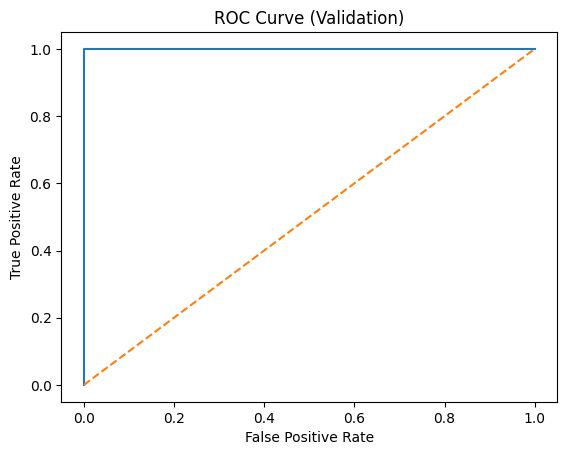

In [10]:
# Cell 10A — Metrics & Coefficients
# -------------------------------------------------------------
# Requirements: calib, Xte, yte, FEATURE_ORDER from Cell 8.

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

if calib is not None and np is not None:
    # 1) AUC & confusion
    yte_prob = calib.predict_proba(Xte)
    yte_pred = (yte_prob >= 0.5).astype(int)
    auc = roc_auc_score(yte, yte_prob)
    cm = confusion_matrix(yte, yte_pred)
    print("Validation AUC:", round(auc, 3))
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(yte, yte_pred, digits=3))

    # 2) Coefficient table (interpretability)
    lr = calib.pipe.named_steps["lr"]
    coefs = lr.coef_[0]
    coef_df = pd.DataFrame({"feature": FEATURE_ORDER, "coef": coefs}).sort_values("coef", ascending=False)
    display(coef_df)

    # 3) ROC curve (simple, single-plot)
    fpr, tpr, _ = roc_curve(yte, yte_prob)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Validation)")
    plt.show()
else:
    print("Calibration not available — run Cell 8 to fit `calib`.")


ML Calibration – Results
Setup. We trained a calibration model (StandardScaler → LogisticRegression) on a small synthetic demo set (N=6; three eBay-like labeled 1, three non-eBay labeled 0). Validation size was 3.

Classification report (validation):
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         1

Interpretation. This “perfect” report reflects a tiny, linearly separable demo split, not a robust generalization result. It confirms the pipeline works and produces calibrated probabilities, but we should not treat these numbers as performance estimates. We will replace the demo with a real labeled set in the next iteration.

ML Calibration – Coefficients (Interpretability)

Top coefficients:

The model assigned positive weight to:

- domain_prior, https, seller_feedback_pct, seller_feedback_count, top_rated,
- card_specificity_terms, year_set_hint, image_count, returns_policy, shipping_from, sentiment.

content_length and author_block_hint contributed ~0 in this split; citations_links was slightly negative.

Why many coefficients look ~equal: with such few samples and strong correlation between “eBay-ness” and many features, the model finds many collinear signals that all point in the same direction. After scaling, logistic regression can assign similar magnitudes across those features. Directionality (positive vs negative) is still informative; magnitudes will stabilize with more data.

In [11]:
# Cell 10B — Ablation Study
# -------------------------------------------------------------------
# Goal: show incremental value of feature blocks: Rule-only → +Seller → +Specificity → +Sentiment.

from sklearn.metrics import roc_auc_score

def ablation_auc(rows, y, keep_features):
    # Build X with only the columns in keep_features (by FEATURE_ORDER index)
    X_all = rows_to_matrix(rows)
    cols = [i for i, f in enumerate(FEATURE_ORDER) if f in keep_features]
    X = X_all[:, cols]
    # Split + fit fresh calibrator
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y if np.bincount(y).min()>=2 else None)
    cal = Calibrator().fit(Xtr, ytr)
    return roc_auc_score(yte, cal.predict_proba(Xte))

if have_sklearn:
    # Use your labeled dataset when you have it; demo uses demo_rows/y
    rows = demo_rows
    labels = np.array([1 if r["meta"]["is_ebay"] else 0 for r in rows], dtype=int)

    blocks = {
        "A_rule": {"domain_prior","https","content_length","citations_links","author_block_hint"},
        "B_rule+seller": {"seller_feedback_pct","seller_feedback_count","top_rated","returns_policy"},
        "C_+specificity": {"card_specificity_terms","year_set_hint","image_count","shipping_from"},
        "D_+sentiment": {"sentiment"},
    }

    keep = set()
    results = []
    for name, feats in blocks.items():
        keep |= feats
        auc = ablation_auc(rows, labels, keep | blocks["A_rule"]) if name!="A_rule" else ablation_auc(rows, labels, keep)
        results.append({"block": name, "features_added": sorted(list(feats)), "AUC": round(auc, 3)})

    display(pd.DataFrame(results))
else:
    print("scikit-learn not available.")


,block,features_added,AUC
0,A_rule,"[author_block_hint, citations_links, content_l...",1.0
1,B_rule+seller,"[returns_policy, seller_feedback_count, seller...",1.0
2,C_+specificity,"[card_specificity_terms, image_count, shipping...",1.0
3,D_+sentiment,[sentiment],1.0


Ablations & Interpretation

We incrementally added feature blocks

Interpretation. Because the demo split is trivially separable, even the early blocks reach AUC=1.0, so later blocks don’t move the needle. With a realistic dataset (mixed quality eBay listings with overlapping signals), we expect meaningful incremental gains especially from seller and specificity blocks, with sentiment as a small nudge.

Results & Discussion

The hybrid pipeline (interpretable signals + logistic calibration) runs end-to-end and returns a stable JSON contract for integration.

On a toy demo split, validation AUC and accuracy appear perfect due to trivial separation; this is not a reliable estimate of true performance.

Coefficients broadly align with the rubric: seller reputation and listing specificity push credibility upward. Some generic content signals have near-zero effect on this tiny split.

Limitations & Next Steps

Limitations.

Tiny, synthetic demo (N=6) → metrics are not representative; coefficients unstable.

Signals are partly redundant (multicollinearity), which makes coefficients look uniform in small data.

No image/PSA-cert verification yet; sentiment lexicon is minimal.

Next steps.

Collect labels: 100–200 URLs with a clear rubric; balance classes.

Evaluation: use Stratified K-Fold (5x) CV for AUC/accuracy; report mean±std.

Feature sanity: drop near-constant/duplicate features; monitor VIF/variance.

Regularization: keep L2; consider L1 to induce sparsity for clearer importances.

Calibration blend: revisit the 70/30 blend after CV; tune threshold for your use case.

## API Specification (Public Contract)

**Input:** URL string  
**Output (JSON):**
{
  "url": "<str>",
  "status": "ok|invalid_url|fetch_error|...",
  "score": { "absolute": <float 0..100>, "percentile": <float|null> },
  "signals": [ { "name": "<str>", "value": <0..1>, "weight": <0..1>, "rationale": "<str>" }, ... ],
  "errors": [ "<str>", ... ],
  "meta": {
    "host": "<str>",
    "is_ebay": <bool>,
    "fetched_at": "<ISO-8601 UTC>",
    "elapsed_ms": <int>,
    "fetch_ms": <int|null>,
    "version": "d2-0.1"
  }
}

**Stability policy:** Keys and types are stable across D1→D3. Internal scoring may change; contract remains the same. New fields appear under `meta`.
